# RO Use Case
## Dataset Ingestion
Current method is from a parquet dataset sitting on s3

In [1]:
from lib.jupyter_functions import *

import boto3, botocore
import os, gc, re, s3fs
from pyarrow.filesystem import S3FSWrapper
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import PolynomialFeatures


np.set_printoptions(threshold=50, edgeitems=20)

s3 = boto3.Session().client('s3')
rsrc = boto3.Session().resource('s3')
fs = s3fs.S3FileSystem()

suffix = pd.to_datetime('today').date().strftime('%Y%m%d')

bucket_path = 'path'
s3_prefix = 'ml_data_rotag_nine'
s3_wide = 'ml_data_rotag_nine/raw_etl/raw_etl'

local_download = 'data/s3_download'
local_prefix = 'data/etl'
local_wide = 'data/etl/lowquality_wide'
local_scaled = 'data/etl/scaled'
local_models = 'xgboost_models'
local_temp = 'data/temp'

taglimits = pd.read_csv('lib/site_tags.csv')\
    .drop_duplicates().sort_values(by='SITE_ID')
taglimits.columns = [re.sub('[^0-9a-zA-Z]+', '_', i.strip().lower()) for i in taglimits.columns.tolist()]

## Selecting only Sites, Assets & Parameters specified by Technical Team for production

### Parameters Used
Parameters are selected based on their availability across as many sites as possible.  The code references a 10 character acronym that can be translated to the following

|**Base Histag**|**KPI Name**|**Comments**|
| --- | --- |---|
|ROFLGCIPTE|CIPTankTemperature|*Typically Not available*|
|ROPRLCALRC|Recovery|*Higher values are highere related to higher permeate output*|
|ROPRLDMCPR|DifferentialPressure|*Difference between input and permeate pressure*|
|ROPRLFEDCV|FeedConductivity|*Almost always measured*|
|ROPRLFEDPH|FeedpH| |
|ROPRLPRIPR|PrimaryPressure|*Incoming pressure before RO filtration*|
|ROPRLPRMCV|PermeateConductivity|*Related to output quality*|
|ROPRLPRMTE|PermeateTemperature|*Used for aqueous geochemical normalization*|


In [2]:
# Select sites
sites = [6521, 50600, 80300]
tags = taglimits[taglimits['site_id'].isin(sites)]

In [3]:
%%time
col_order = ['site_id', 'assetId', 'event_datetime',
             'cip_tag', 'ROPRLCALRC', 'ROPRLDMCPR',
             'ROPRLFEDCV', 'ROPRLFEDPH', 'ROPRLPRIPR',
             'ROPRLPRMCV', 'ROPRLPRMTE', 'ROFLGCIPLV',
             'ROFLGCIPTE', 'ROPRLOPRM']
s3_wide = 'ml_data_rotag_nine/raw_etl/raw_etl'
s3_wide_pq = 's3://{}/{}'.format(bucket_path, s3_wide)
wide_list = []
for i in tqdm(tags.asset_id.unique()):
    dataset = pq.ParquetDataset(s3_wide_pq, filesystem = fs,
                               filters=[('assetId', '=', i)])
    try:
        dataset.read()
    except Exception as e:
        print(e, i)
        continue
    df = dataset.read().to_pandas()
#     print('Asset_ID {} has {} duplicated rows out of {} total rows ({}%)'.format(i,df[df.duplicated(subset=['assetId','event_datetime'])].shape[0],df.shape[0],(df[df.duplicated(subset=['assetId','event_datetime'])].shape[0])/(df.shape[0])*100 ))
    df = df.drop_duplicates(subset=['assetId','event_datetime'])
    df = df[col_order]
    wide_list.append(df)
    del df
    gc.collect()
df_ro = pd.concat(wide_list)
df_ro['assetId'] = df_ro['assetId'].astype(np.int64())
df_ro['event_datetime'] = pd.to_datetime(df_ro['event_datetime'], unit='s')
df_ro = df_ro.replace(-99, np.nan).sort_values(by=['assetId', 'event_datetime'])

Must pass at least one table 261906

CPU times: user 5.04 s, sys: 472 ms, total: 5.52 s
Wall time: 11.9 s


## Scale & Add features for training

In [ ]:
## Create Features based on lags and rolling mean
backward_lags = 16 # 4 hours of previous times
forward_lags = 4 # selecting the forward 1 hour for modeling
roll_int_day = 96 # Number of 15 min intervals in 24 hours (1 day rolling mean)
roll_int_halfday = 48 # Half day rolling mean
roll_int_2day = 192 # 2 day (48 hour) rolling mean
poly = PolynomialFeatures(3) # Polynomial features & interactions

In [56]:
%%time
# Scale & add features by asset, then save to Parquet dataset
col_order = ['site_id', 'assetId', 'event_datetime',
             'cip_tag', 'ROPRLCALRC', 'ROPRLDMCPR',
             'ROPRLFEDCV', 'ROPRLFEDPH', 'ROPRLPRIPR',
             'ROPRLPRMCV', 'ROPRLPRMTE', 'ROFLGCIPLV',
             'ROFLGCIPTE', 'ROPRLOPRM']
no_calc = ['site_id', 'cip_tag', 'assetId', 'event_datetime']
calc = [cl for cl in col_order if cl not in no_calc]
s3_wide = 'ml_data_rotag_nine/raw_etl/raw_etl'
s3_wide_pq = 's3://{}/{}'.format(bucket_path, s3_wide)

wide_list = []
for i in tqdm(tags.asset_id.unique()):
    # Read in individual assets
    dataset = pq.ParquetDataset(s3_wide_pq, filesystem = fs,
                               filters=[('assetId', '=', i)])
    try:
        dataset.read()
    except Exception as e:
        print(e, i)
        continue
    df = dataset.read().to_pandas()
    df = df.drop_duplicates(subset=['assetId','event_datetime'])
    df = df[col_order]
    df['assetId'] = df['assetId'].astype(np.int64())
    df = df.replace(-99, np.nan).sort_values(by=['assetId', 'event_datetime'])
    
    # 
    df_scaled = df.loc[:,calc].apply(z_score)
    df = pd.concat((df.loc[:,no_calc],df_scaled),axis=1, ignore_index=True)
    df.columns = no_calc + calc

    # Using the scaled data to create features
    lagb_df = lag_backward(df[calc],backward_lags)
    lagf_df = lag_forward(df[calc],forward_lags)
    roll_day_df = rolling_mean(df, no_calc,roll_int_day).fillna(method='bfill')
    roll_halfday_df = rolling_mean(df, no_calc, roll_int_halfday).fillna(method='bfill')
    roll_2day_df = rolling_mean(df, no_calc, roll_int_2day).fillna(method='bfill')
    poly_df = pd.DataFrame(poly.fit_transform(df[calc].apply(lambda x: x.fillna(x.mean()),axis=0).fillna(0)),
                           columns=poly.get_feature_names(input_features=calc))\
                .drop(columns=calc+['1'])\
                .replace(0,np.nan)

    # Concatenate the features into a dataframe with the non-calculated columns first
    temp = pd.concat((df, roll_day_df, roll_halfday_df, lagb_df, lagf_df, poly_df), axis=1)
    wide_list.append(temp)
ro_wide = pd.concat(wide_list)

Must pass at least one table 261906

CPU times: user 18.5 s, sys: 18 s, total: 36.5 s
Wall time: 19.2 s


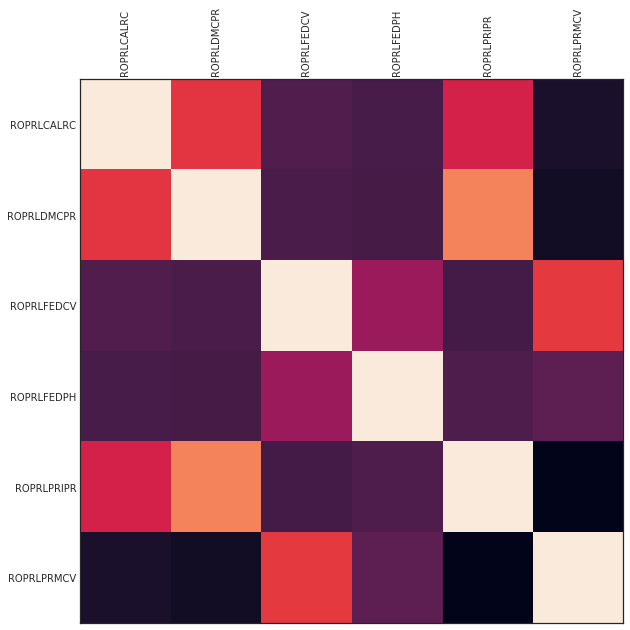

In [57]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);
    
plot_corr(ro_wide[calc].dropna(axis=1, how='all'))

|**Base Histag**|**KPI Name**|**Comments**|
| --- | --- |---|
|ROFLGCIPTE|CIPTankTemperature|*Typically Not available*|
|ROPRLCALRC|Recovery|*Higher values are highere related to higher permeate output*|
|ROPRLDMCPR|DifferentialPressure|*Difference between input and permeate pressure*|
|ROPRLFEDCV|FeedConductivity|*Almost always measured*|
|ROPRLFEDPH|FeedpH| |
|ROPRLPRIPR|PrimaryPressure|*Incoming pressure before RO filtration*|
|ROPRLPRMCV|PermeateConductivity|*Related to output quality*|
|ROPRLPRMTE|PermeateTemperature|*Used for aqueous geochemical normalization*|

## Build train/test/validation dataset

In [78]:
def build_traintest(df, not_modeled_lst, train_percent, dependent_var):
    df = df.fillna(-99)
    ro_assets = df.assetId.unique().tolist()
    num_assets_train = int(len(ro_assets) * (train_percent / 100))
    trts = random.sample(ro_assets, num_assets_train)
    cols = [cl for cl in df.columns.tolist() if cl not in not_modeled_lst]
    feature_cols = [cl for cl in df.columns.tolist() if cl not in not_modeled_lst + [dependent_var]]

    train_df = df[df['assetId'].isin([i for i in ro_assets if i not in trts])]
    train_df = train_df[cols]
    dtrain_dm = xgb.DMatrix(train_df[feature_cols].values, train_df.loc[:, dependent_var].values,
                         feature_names=feature_cols, missing=-99)
    print('Assets in Training\t{}'.format([i for i in ro_assets if i not in trts]))

    test_df = df[df['assetId'].isin(trts)]
    test_df = test_df[cols]
    dtest_dm = xgb.DMatrix(test_df[feature_cols].values, test_df.loc[:, dependent_var].values,
                        feature_names=feature_cols, missing=-99)
    print('Assets in Testing\t{}'.format(trts))

    values_dm = xgb.DMatrix(df[feature_cols].values, df.loc[:, dependent_var].values, 
                         feature_names=feature_cols, missing=-99)

    print('\n\n{} Clean events in Training of {} observations\n{} Clean events in Testing of {} observations'.format(
        train_df[train_df[dependent_var] == 1].shape[0], train_df.shape[0],
        test_df[test_df[dependent_var] == 1].shape[0], test_df.shape[0]
        )
    )

    return train_df, dtrain_dm, test_df, dtest_dm, values_dm

In [80]:
%%time
not_modeled = ['site_id','event_datetime', 'assetId']
train_pct = 60
train, dtrain, test, dtest, values = build_traintest(ro_wide, not_modeled, train_pct, 'cip_tag')
values.save_binary('data/20190220_xgb_dataset_lowquality.buffer')
train.head()

Assets in Training	[282838, 282856, 54658]
Assets in Testing	[261907, 282854, 287681, 54659]


1319 Clean events in Training of 194420 observations
1812 Clean events in Testing of 252659 observations
CPU times: user 5.2 s, sys: 4.94 s, total: 10.1 s
Wall time: 8.45 s


In [82]:
gc.collect()

2449

In [84]:
# set parameters
param = {
    'objective':'binary:logistic',
    'learning_rate':.005,
    'seed':10,
    'silent':1,
    'eval_metric':['auc', 'error'],
    'subsample':0.2,
    'gamma':0.3,
    'max_depth':2,
    'min_child_weight':8,
    'n_estimator':1000,
    'missing':-99,
    'min_samples_split':1
}
num_round = 20
# specify validations set to watch performance
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
bst_1 = xgb.train(param, dtrain, num_round, watchlist)
bst_1.save_model('XGboost_{}.model'.format(suffix))

# make prediction
preds_test = bst_1.predict(dtest)
# Predict all values and add as new column
preds = bst_1.predict(values)

[0]	eval-auc:0.890501	eval-error:0.004401	train-auc:0.864508	train-error:0.002381
[1]	eval-auc:0.892182	eval-error:0.004342	train-auc:0.866426	train-error:0.002459
[2]	eval-auc:0.892184	eval-error:0.004326	train-auc:0.866429	train-error:0.002417
[3]	eval-auc:0.901787	eval-error:0.004342	train-auc:0.873599	train-error:0.002407
[4]	eval-auc:0.903713	eval-error:0.004381	train-auc:0.873591	train-error:0.002253
[5]	eval-auc:0.912761	eval-error:0.004377	train-auc:0.883025	train-error:0.002243
[6]	eval-auc:0.912763	eval-error:0.004377	train-auc:0.883024	train-error:0.002243
[7]	eval-auc:0.912761	eval-error:0.004377	train-auc:0.883019	train-error:0.002243
[8]	eval-auc:0.912754	eval-error:0.004389	train-auc:0.883029	train-error:0.002253
[9]	eval-auc:0.937824	eval-error:0.004389	train-auc:0.907943	train-error:0.002243
[10]	eval-auc:0.938357	eval-error:0.004389	train-auc:0.908309	train-error:0.002258
[11]	eval-auc:0.94082	eval-error:0.004385	train-auc:0.909046	train-error:0.002273
[12]	eval-auc:0

## Determine best prediction threshold for binary classification
Logistic regression threshold based on F-Score

In [108]:
%%capture
precision_recall = []
precis_recl = []
for i in tqdm(np.arange(0.2,0.8,.005).round(3)):
    label_test = dtest.get_label()
    c = (preds_test > i).astype(int)
    labels = values.get_label()
    preds_binary = (preds >i).astype(int)
    # Create lists for plotting precision and recall for Validation and Full datasets
    precision_recall.append(list(precision_recall_fscore_support(preds_binary, 
                                                                 labels, 
                                                                 average='binary'))+[i])

In [107]:
# Max F-score
temp_threshold = [x[4] for x in precision_recall if x[2] == np.max([i[2] for i in (precision_recall)])]
preds_binary = (preds > temp_threshold[0]).astype(int)
print(i,'\n',confusion_matrix(preds_binary, labels))

0.8 
 [[443047    665]
 [   901   2466]]


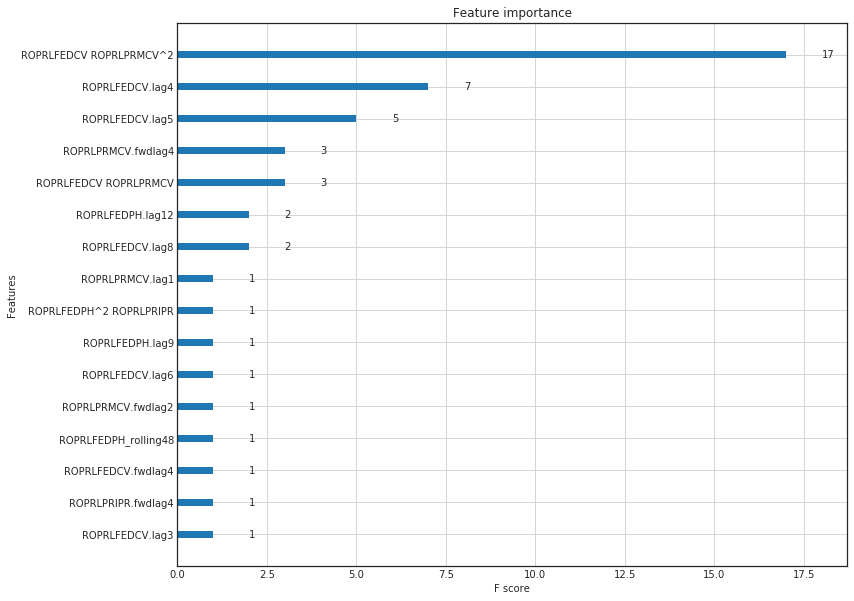

In [86]:
%matplotlib inline
# plot feature importance
_ = my_plot_importance(bst_1, figsize=(12,10), max_num_features=30)

|**Base Histag**|**KPI Name**|**Comments**|
| --- | --- |---|
|ROFLGCIPTE|CIPTankTemperature|*Typically Not available*|
|ROPRLCALRC|Recovery|*Higher values are highere related to higher permeate output*|
|ROPRLDMCPR|DifferentialPressure|*Difference between input and permeate pressure*|
|ROPRLFEDCV|FeedConductivity|*Almost always measured*|
|ROPRLFEDPH|FeedpH| |
|ROPRLPRIPR|PrimaryPressure|*Incoming pressure before RO filtration*|
|ROPRLPRMCV|PermeateConductivity|*Related to output quality*|
|ROPRLPRMTE|PermeateTemperature|*Used for aqueous geochemical normalization*|

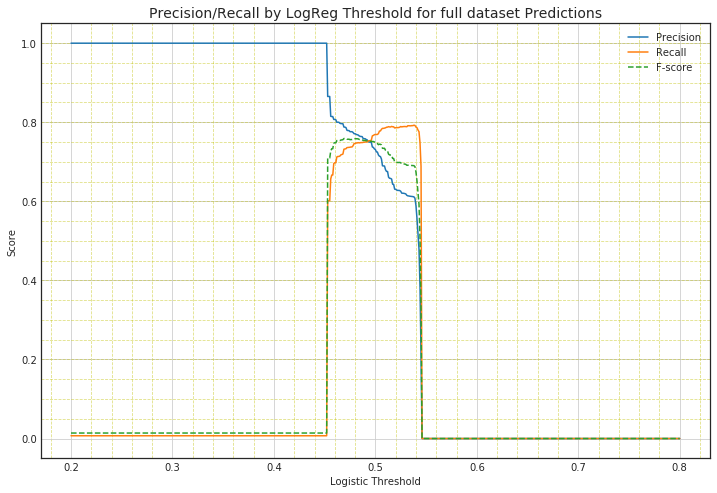

In [87]:
plot_precis_recall(precision_recall, 'Precision/Recall by LogReg Threshold for full dataset Predictions')

## Add predictions to dataset based on max F-score

In [102]:
# Add preds to dataset
filename = 'data/df_ro_preds{}.parquet'.format(suffix)
if os.path.isfile(filename):
    print("Reading Preds File")
    df_ro = pd.read_parquet(filename)
else:
    print("Adding preditions to in-memory file using F-Score to determine log Reg Threshold")
    df_ro = ro_wide[col_order]
    df_ro['preds_xg'] = preds_binary
    df_ro = df_ro.sort_values(by=['assetId', 'event_datetime'])
    df_ro = df_ro.replace(to_replace=-99, value=np.nan)
    # Write to file
    df_ro.to_parquet('data/df_ro_preds{}.parquet'.format(suffix))
    rsrc.Bucket(bucket_path).Object(os.path.join(s3_prefix, 'raw/df_ro_preds{}.parquet'.format(suffix)))\
        .upload_file('data/df_ro_preds{}.parquet'.format(suffix))

Adding preditions to in-memory file using F-Score to determine log Reg Threshold


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Convert predictions and raw values to long format for Tableau

In [104]:
# Convert to long format
long_filename = 'data/df_ro_preds_long_{}.parquet'.format(suffix)
if os.path.isfile(long_filename):
    print('reading from file')
    df_ro = pd.read_parquet(long_filename)
    
else:
    print('Computing Long format')
    ##
    df_ro2 = df_ro.melt(id_vars=['event_datetime', 'assetId', 'cip_tag', 'preds_xg'], 
               var_name='base_histag', value_name='event_value')
    df_ro2 = df_ro2.drop_duplicates(keep='first')
    df_ro2['assetId'] = df_ro2['assetId'].astype(int)
    df_ro2['event_datetime'] = pd.to_datetime(df_ro2['event_datetime'], unit='s')
    df_ro2 = df_ro2.sort_values(by=['assetId', 'base_histag', 'event_datetime'])
    ##
    asst_list = []
    for asset in tqdm(df_ro2.assetId.unique().tolist()):
        tmp = df_ro2[df_ro2['assetId']==asset]
        for tag in tmp.base_histag.unique().tolist():
            tmp_tag = tmp[tmp['base_histag']==tag][['event_datetime', 'cip_tag']]
            tmp_tag = tmp_tag.set_index(pd.DatetimeIndex(tmp_tag['event_datetime'])).drop(columns='event_datetime')\
                .sort_index()
            ## Number of intervals between cleaning events
            tmp_tag2 = pd.DataFrame(tmp_tag[tmp_tag['cip_tag']==1])
            tmp_tag2['cip_time_diff'] = tmp_tag2.index.to_series().diff().dt.seconds.div(60, fill_value=0)
            rng = pd.period_range(start=tmp_tag.index.min(),
                                 end = tmp_tag.index.max(),
                                 freq='15T')\
                .to_timestamp()
            tmp_tag2 = tmp_tag2.reindex(index=rng).fillna(-99).reset_index()
            ## Daily Sum of cleaning tags
            dailysum = tmp_tag.resample('D').sum().reindex(tmp_tag.index, method='ffill')
            dailysum = dailysum.reset_index()
            dailysum.columns = ['event_datetime', 'cip_daily_sum']
            dailysum['assetId'] = asset
            dailysum['base_histag']=tag
            cip_summaries = tmp_tag2.merge(dailysum, left_on='index', right_on='event_datetime')\
                .drop(columns=['index'])
            cols = ['event_datetime', 'assetId', 'base_histag', 
                    'cip_time_diff', 'cip_daily_sum']
            cip_summaries = cip_summaries[cols]
            asst_list.append(cip_summaries)
    asst_concat = pd.concat(asst_list, ignore_index=True)
    asst_concat.head()

    df_ro2 = df_ro2.merge(asst_concat, left_on=['event_datetime', 'assetId', 'base_histag'],
                right_on=['event_datetime', 'assetId', 'base_histag'])
    cols = ['event_datetime', 'assetId', 'base_histag', 'event_value',
           'cip_tag', 'cip_time_diff', 'cip_daily_sum', 'preds_xg']
    df_ro2 = df_ro2[cols]
#     df_ro2.head()
    print('Saving to local and s3')
    df_ro2.to_parquet('data/df_ro_preds_long_{}.parquet'.format(suffix))

Using memory



Saving to local and s3


In [106]:
# Saving as CSV for tableau
df_ro2 = df_ro2.replace(-99, np.nan)
df_ro2.to_csv('data/df_ro_preds_long_{}.csv'.format(suffix), index=False)